In [1]:
'''
    This is another example of Generative Adversarial Network
    This network uses MNIST dataset to generate numbers
    This tutorial is taken from https://github.com/yunjey
    Thank you yunjey.
'''

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

tranform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5),
                         std = (0.5, 0.5, 0.5))
])

mnist_dataset = datasets.MNIST(root = '../datasets/mnist/', train=True, transform=tranform)

dataloader = DataLoader(dataset=mnist_dataset, batch_size=100, shuffle=True)

In [2]:
# Define classes of MNIST
classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')

# Helper function to show sample images
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([100, 1, 28, 28])
<class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'>
Label:     4     5     3     6     8     1     4     7     8     3     1     9     2     5     9     1     6     2     3     8     8     3     1     3     5     5     8     8     9     2     8     6     4     6     5     9     1     8     5     9     8     8     2     2     8     5     8     4     1     0     2     6     3     4     3     3     5     9     6     0     4     8     0     9     7     0     7     7     1     1     1     0     9     1     8     3     0     0     7     7     3     4     3     1     4     1     1     7     2     1     0     4     5     1     8     1     8     7     1     2


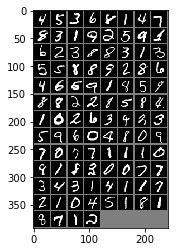

In [3]:
# Display sample training data
dataiter = iter(dataloader)
images, labels = dataiter.next()

batch_size = images.size(0)
print(images.size())

# images = Variable(images.view(batch_size, -1))
# print(images.size())

real_labels = Variable(torch.ones(batch_size))
real_labels_1 = Variable(labels)
print(type(real_labels))
print(type(real_labels_1))

imshow(torchvision.utils.make_grid(images))
print('Label:', ' '.join('%5s' % classes[labels[j]] for j in range(100)))

In [4]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 784),
    nn.Tanh())

In [5]:
if torch.cuda.is_available():
    D.cuda()
    G.cuda()

In [6]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=1e-3)
g_optimizer = optim.Adam(G.parameters(), lr=1e-3)

In [7]:
def g_save_checkpoint(g_state, g_file = 'generator.pth.tar'):
    torch.save(g_state, g_file)
    
def d_save_checkpoint(d_state, d_file = 'discriminator.pth.tar'):
    torch.save(d_state, d_file)

In [8]:
starting_epoch = 0
total_epoch = 50

In [9]:
import os.path as path

if path.isfile('./generator.pth.tar') and path.isfile('./discriminator.pth.tar'):
    g_checkpoint = torch.load('./generator.pth.tar')
    d_checkpoint = torch.load('./discriminator.pth.tar')
    
    starting_epoch = g_checkpoint['epoch']
    
    G.load_state_dict(g_checkpoint['state_dict'])
    g_optimizer.load_state_dict(g_checkpoint['g_optimizer'])
    
    D.load_state_dict(d_checkpoint['state_dict'])
    d_optimizer.load_state_dict(d_checkpoint['d_optimizer'])
    
    print("Starting from epoch : %d" % epoch)

In [10]:
# Start training
for epoch in range(starting_epoch, total_epoch):
    for i, (images, labels) in enumerate(dataloader):
        # Build mini-batch dataset
        batch_size = images.size(0)
        images = Variable(images.view(batch_size, -1))
        real_labels = Variable(torch.ones(batch_size))
        fake_labels = Variable(torch.zeros(batch_size))

        #============= Train the discriminator =============#
        # Compute loss with real images
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute loss with fake images
        z = Variable(torch.randn(batch_size, 64))
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #=============== Train the generator ===============#
        # Compute loss with fake images
        z = Variable(torch.randn(batch_size, 64))
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # Backprop + Optimize
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch, total_epoch, i+1, 600, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))
        
    
    # Save real images
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 28, 28)
        save_image(denorm(images.data), './data/real_images.png')
    
    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images.data), './data/fake_images-%d.png' %(epoch+1))
    
    # Save checkpoint
    g_save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': G.state_dict(),
        'g_optimizer': g_optimizer.state_dict()})
    
    d_save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': D.state_dict(),
        'd_optimizer': d_optimizer.state_dict()})
    
# Save checkpoint
g_save_checkpoint({
    'epoch' : epoch + 1,
    'state_dict' : G.state_dict(),
    'g_optimizer' : g_optimizer.state_dict()}, g_file = 'final_generator.pkl')

d_save_checkpoint({
    'epoch' : epoch + 1,
    'state_dict' : D.state_dict(),
    'd_optimizer' : d_optimizer.state_dict()}, d_file = 'final_discriminator.pkl')

print('Finished training')

Epoch [0/50], Step[300/600], d_loss: 1.2168, g_loss: 8.2564, D(x): 0.89, D(G(z)): 0.19
Epoch [0/50], Step[600/600], d_loss: 0.4526, g_loss: 4.6976, D(x): 0.80, D(G(z)): 0.09
Epoch [1/50], Step[300/600], d_loss: 0.0730, g_loss: 4.8759, D(x): 0.97, D(G(z)): 0.03
Epoch [1/50], Step[600/600], d_loss: 0.0377, g_loss: 13.1153, D(x): 1.00, D(G(z)): 0.02
Epoch [2/50], Step[300/600], d_loss: 0.0187, g_loss: 13.0845, D(x): 1.00, D(G(z)): 0.01
Epoch [2/50], Step[600/600], d_loss: 0.0115, g_loss: 12.6466, D(x): 1.00, D(G(z)): 0.01
Epoch [3/50], Step[300/600], d_loss: 0.0006, g_loss: 13.9314, D(x): 1.00, D(G(z)): 0.00
Epoch [3/50], Step[600/600], d_loss: 0.0000, g_loss: 11.1069, D(x): 1.00, D(G(z)): 0.00
Epoch [4/50], Step[300/600], d_loss: 0.0000, g_loss: 11.4050, D(x): 1.00, D(G(z)): 0.00
Epoch [4/50], Step[600/600], d_loss: 0.0000, g_loss: 11.5204, D(x): 1.00, D(G(z)): 0.00
Epoch [5/50], Step[300/600], d_loss: 0.0008, g_loss: 19.9840, D(x): 1.00, D(G(z)): 0.00
Epoch [5/50], Step[600/600], d_loss

KeyboardInterrupt: 